In [1]:
push!(LOAD_PATH, pwd()*"/..")
import_path = "/Users/julian/Harvard/research/nowak/indirect_rec/src"
push!(LOAD_PATH, import_path)
using LightGraphs, Epidemics, GraphGeneration,IM
using GraphGeneration
using NLsolve
using PyPlot, Distributions
using DegreeDistribution
using StatsBase
using GraphCreation
using Clustering
using DataAnalysis
using TwoLevelGraphs
plt[:rc]("text",usetex=true)


Use "Graph{P}(...) where P" instead.


In [690]:
function get_alpha_beta(N,c_r,y_n)
    n_n = Int(N*y_n)#y_n*N
    beta = get_beta(N,c_r,n_n)#4.0/(c_r*n_n)
    alpha = get_alpha(N,c_r,n_n)#(N*beta)/n_n
    return alpha,beta
end
    

function get_t(N,k,m,l)
    r = k -l
    t = TwoLevel(Int(ceil(N/m)*m),m,l,r)
    return t
end

function get_community_graph_fixation_ratio(t,alpha,beta)
    return get_fixation_MC(t,alpha,beta)/get_fixation_MC(t,alpha,beta,true)
#     yy,pp,pp_reverse = get_single_community_fixation(t,alpha,beta,false)
#     return pp[end]/pp_reverse[end]
end

function get_theory_sim_fixation_ratio(t,alpha,beta,num_trials,use_model = false)
    success = true
    if use_model
        yys,pps,_ = get_p_reach_theory(t,alpha,beta,N,true,200)
    else
        yys,pps = get_simulation_yy_pp(t,alpha,beta,num_trials)
    end
#     yy,pp,pp_reverse = get_single_community_fixation(t,alpha,beta)
#     pfixth = pp[end]
    pfixth = get_fixation_MC(t,alpha,beta)
    pfix = pps[end]
    if yys[end] < 0.99
        println("simulation didn't reach 1.0")
        println("theory suggests at least $(1/pfixth)")
        success = false
        pfix = 0
#         return -1
    end
    figure(1)
    loglog(yys,pps)
    return pfix/pfixth, success,pfix,pfixth
end


using Dierckx

function get_simulation_yy_pp(t,alpha,beta,num_trials=100)
    im_normal = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
    fixation_threshold = 1.0

    verbose = false
    ###Set to true if we want by-node information on infecteds (much more data!)
    carry_by_node_information = false
    graph_model = true
    in_parallel = true
    T = generate_regular_two_level_graph(t)
    graph_fn = () -> T 
    graph_data = TwoLevelGraph(LightGraphs.Graph(),t,get_clusters(t))
    graph_information = GraphInformation(graph_fn,Graph(),carry_by_node_information,graph_data)

    # @time runs = run_epidemics_parallel(num_trials,() -> run_epidemic_graph(N,im_normal,graph_information,fixation_threshold),in_parallel);
    # yy,pp = get_p_reach(runs)
    # yy /= N
    @time runs = run_epidemics_parallel(num_trials,() -> run_epidemic_graph_gillespie(t.N,im_normal,graph_information,fixation_threshold),in_parallel);
    yys,pps = get_p_reach(runs)
    yys /= N;
    return yys,pps
end



function get_dmp_dmm(t,j,alpha,beta)
    i_orig = t.i
    t.i = i_orig + j 
    z_s = TwoLevelGraphs.get_y_local(t,j,true)
    z_sq_s = TwoLevelGraphs.get_y_squared_local(t,j,true)
    z_i = TwoLevelGraphs.get_y_local(t,j,false)
#     println("j: $j")
#     println("z_s: $(z_s)")
#     println("z_i: $(z_i)")
#     println()

    y_i = j/m
    
    
    dmp = (1-y_i)*(z_s + alpha*z_sq_s)
    dmm = (y_i)*(1-z_i)*(1 + beta)
    
    if j == 0 || j == t.m
        dmm = 0 #j == 0
        dmp = 0 #j ==t.m
    end

    t.i = i_orig
    return dmp,dmm
end

function get_fixation_MC(t,alpha,beta,reverse=false)
    y = 0.0
    t.i = t.N*y

    j_range = collect(0:t.m)
    y_range = j_range/t.m
    s_arr = zeros(Float64,size(j_range))
    dmp_arr = zeros(Float64,size(j_range))
    dmm_arr = zeros(Float64,size(j_range))
    s_plus_arr = zeros(Float64,size(j_range))
    for (idx,j) in enumerate(j_range)
        dmp,dmm = get_dmp_dmm(t,j,alpha,beta)
        dmp_arr[idx] = dmp
        dmm_arr[idx] = dmm
    end
    if reverse
        tmp = dmp_arr
        dmp_arr = dmm_arr
        dmm_arr = tmp
        dmp_arr = dmp_arr[end:-1:1]
        dmm_arr = dmm_arr[end:-1:1]
    end
        
    M = zeros(Float64,m+1,m+1)
    Q = zeros(Float64,m-1,m-1)
#     for (idx,j) in enumerate(j_range)
    for idx in 2:m
        M[idx,idx+1] = dmp_arr[idx]
        M[idx,idx-1] = dmm_arr[idx]
        M[idx,idx] = -dmp_arr[idx]-dmm_arr[idx]
    end
    Q = M[2:m,2:m]
    W1 = M[2:m,1]
    W2 = M[2:m,m+1]
    return(- inv(Q)*W2)[1]
    
#     sanity check
#     eps = 0.5
#     P = eye(m+1) + eps*M
#     s0 = zeros(m+1)
#     s0[2] = 1.0
#     println((s0'*(P^100000))[end])
    
#     tot = 0
#     prod_vec = zeros(m)
#     lambdas = dmp_arr[2:m]
#     mus = dmm_arr[2:m]
#     for i in 1:m
#         prod_vec[i] = prod(lambdas[1:i-1])*prod(mus[i:end])
#     end
# #     prod_vec[1] = prod(mus)
# #     prod_vec[end] = prod(lambdas)
#     return prod(lambdas)/sum(prod_vec)
        
#     M[1,1] = 1
#     M[end,end] = 1
#     pi = eig(M')
    
#     return pi
end

function get_single_community_fixation(t,alpha,beta,plotting=false)
    y = 0.0
    t.i = t.N*y

    j_range = collect(0:t.m)
    y_range = j_range/t.m
    s_arr = zeros(Float64,size(j_range))
    dmp_arr = zeros(Float64,size(j_range))
    dmm_arr = zeros(Float64,size(j_range))
    s_plus_arr = zeros(Float64,size(j_range))
    for (idx,j) in enumerate(j_range)
        dmp,dmm = get_dmp_dmm(t,j,alpha,beta)
        s_arr[idx] = (dmp-dmm)
        s_plus_arr[idx] = (dmp+dmm)
        dmp_arr[idx] = dmp
        dmm_arr[idx] = dmm
    end

    # plot(j_range,s_arr./s_plus_arr)
    # plot(j_range,s_arr,"-")
    if plotting
        plot(j_range,dmm_arr,"--")
        plot(j_range,dmp_arr,"-")
    end


    interpolation_order = 3
    s_fn(x) = evaluate(Spline1D(y_range,s_arr,k=interpolation_order,bc="extrapolate"),x)
    splus_fn(x) = evaluate(Spline1D(y_range,s_plus_arr,k=interpolation_order,bc="extrapolate"),x)

    s_m_fn(x) = evaluate(Spline1D(1-y_range[end:-1:1],-s_arr[end:-1:1],k=interpolation_order,bc="extrapolate"),x)

    
    if plotting
        figure()
        plot(y_range,s_fn(y_range))
        plot(y_range,s_m_fn(y_range))
    end
    yy = y_range[1:end]
    pp_reverse = P_reach_fast(s_m_fn,splus_fn,t.m,1.0/t.m,yy)
    pp = P_reach_fast(s_fn,splus_fn,t.m,1.0/t.m,yy)
    return yy,pp,pp_reverse
end

get_single_community_fixation (generic function with 2 methods)

# Make heatmap plot as a function of $y_n$ and $N$ (or perhaps $clustering$ and $N$) showing location of phase transition

In [748]:
N = 1000;k=20;m=20;l=10
t = get_t(N,k,m,l)
alpha,beta = 5.0,0.05
println(get_dmp_dmm(t,2,alpha,beta))
num_trials = 100
# sim_ratio, succ,pfix,pfixth = get_theory_sim_fixation_ratio(t,alpha,beta,num_trials)
# println(pfix,"\n",pfixth)
println(get_community_graph_fixation_ratio(t, alpha, beta))
# println(get_single_community_fixation(t,alpha,beta)[2][end])
# println(get_fixation_MC(t,alpha,beta))

(0.06513157894736842, 0.10223684210526317)
6.527398493122056e-5


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Float64}, ::Int64, ::Int64) at ./deprecated.jl:57
 [3] trust_region_(::NLsolve.DifferentiableMultivariateFunction, ::Array{Float64,1}, ::Float64, ::Float64, ::Int64, ::Bool, ::Bool, ::Bool, ::Float64, ::Bool) at /Users/julian/.julia/v0.6/NLsolve/src/trust_region.jl:82
 [4] #nlsolve#17(::Symbol, ::Float64, ::Float64, ::Int64, ::Bool, ::Bool, ::Bool, ::Function, ::Float64, ::Bool, ::NLsolve.#nlsolve, ::NLsolve.DifferentiableMultivariateFunction, ::Array{Float64,1}) at /Users/julian/.julia/v0.6/NLsolve/src/nlsolve_func_defs.jl:24
 [5] (::NLsolve.#kw##nlsolve)(::Array{Any,1}, ::NLsolve.#nlsolve, ::NLsolve.DifferentiableMultivariateFunction, ::Array{Float64,1}) at ./<missing>:0
 [6] #nlsolve#19(::Symbol, ::Float64, ::Float64, ::Int64, ::Bool, ::Bool, ::Bool, ::Function, ::Float64, ::Bool, ::Bool, ::NLsolve.#nlsolve, ::TwoLevelGraphs.#fn#12{TwoLevelGraphs.TwoLevel,Float64,Float64}, ::Array{Float64,1}) at /Us

1.871517814049828e-11


::String) at ./loading.jl:515
 [17] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/julian/.julia/v0.6/IJulia/src/execute_request.jl:160
 [18] eventloop(::ZMQ.Socket) at /Users/julian/.julia/v0.6/IJulia/src/eventloop.jl:8
 [19] (::IJulia.##11#14)() at ./task.jl:335
while loading In[757], in expression starting on line 17


 13.278410 seconds (161.04 M allocations: 3.469 GiB, 6.36% gc time)
3.076713217471048e-11
 12.677534 seconds (158.32 M allocations: 3.409 GiB, 6.35% gc time)
4.980272134051904e-11
 12.388455 seconds (157.05 M allocations: 3.381 GiB, 6.53% gc time)
7.945860268616715e-11
 12.230083 seconds (155.74 M allocations: 3.352 GiB, 6.37% gc time)
1.2507002431065722e-10
 12.237225 seconds (154.38 M allocations: 3.322 GiB, 6.34% gc time)
1.9438077865601146e-10
 12.220836 seconds (153.63 M allocations: 3.306 GiB, 6.38% gc time)
2.9851765364277825e-10
 11.979765 seconds (152.19 M allocations: 3.275 GiB, 6.45% gc time)
4.5331698458655425e-10
 11.922432 seconds (151.96 M allocations: 3.270 GiB, 6.51% gc time)
6.811169540539864e-10
 11.841191 seconds (151.08 M allocations: 3.251 GiB, 6.39% gc time)
1.0131603405567082e-9
 

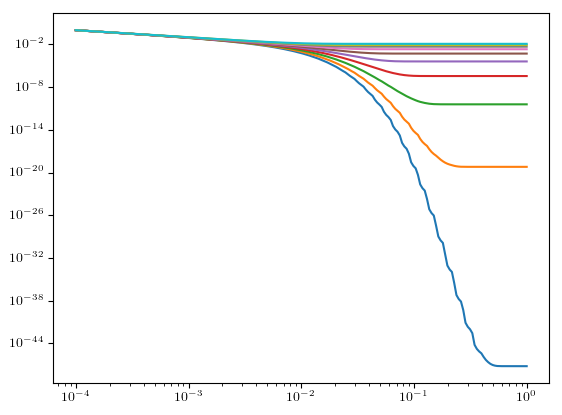

11.899783 seconds (151.41 M allocations: 3.259 GiB, 6.50% gc time)


In [757]:
## dependence on a single variable
N = 10000;k=20;m=20;l=10
N_range = [100,1000,10000]#,200,320,440]#,800,1600,3200]
alpha_range = 0.1:0.1:1.0#collect(0.01:0.1:0.5)
beta = 0.05
l1 = length(N_range)
# l2 = length(N_range)
comm_ratio_vec = zeros(Float64,l1)
pfixth_vec = zeros(Float64,l1)
pfix_vec = zeros(Float64,l1)
sim_ratio_vec = zeros(Float64,l1)
succ_vec = zeros(Bool,l1)
# beta = 0.05
num_trials = 4000
use_model = true
# for (i,alpha) in enumerate(alpha_range)
for (i,N) in enumerate(N_range)
    t = get_t(N,k,m,l)
    comm_ratio_vec[i] = get_community_graph_fixation_ratio(t,alpha,beta)
    println(comm_ratio_vec[i])
    @time sim_ratio, succ,pfix,pfixth = get_theory_sim_fixation_ratio(t,alpha,beta,num_trials, use_model)
    sim_ratio_vec[i] = sim_ratio
    succ_vec[i] = succ
    pfix_vec[i] = pfix
    pfixth_vec[i] = pfixth
#     comm_ratio_vec[i] = comm_ratio_arr[i]#get_community_graph_fixation_ratio(t,alpha,beta)
#     sim_ratio_vec[i] = sim_ratio_arr[i]
#     succ_vec[i] = succ_arr[i]
#     pfix_vec[i] = pfix_arr[i]
#     pfixth_vec[i] = pfixth_arr[i]
end
    

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Float64}, ::Int64, ::Int64) at ./deprecated.jl:57
 [3] trust_region_(::NLsolve.DifferentiableMultivariateFunction, ::Array{Float64,1}, ::Float64, ::Float64, ::Int64, ::Bool, ::Bool, ::Bool, ::Float64, ::Bool) at /Users/julian/.julia/v0.6/NLsolve/src/trust_region.jl:82
 [4] #nlsolve#17(::Symbol, ::Float64, ::Float64, ::Int64, ::Bool, ::Bool, ::Bool, ::Function, ::Float64, ::Bool, ::NLsolve.#nlsolve, ::NLsolve.DifferentiableMultivariateFunction, ::Array{Float64,1}) at /Users/julian/.julia/v0.6/NLsolve/src/nlsolve_func_defs.jl:24
 [5] (::NLsolve.#kw##nlsolve)(::Array{Any,1}, ::NLsolve.#nlsolve, ::NLsolve.DifferentiableMultivariateFunction, ::Array{Float64,1}) at ./<missing>:0
 [6] #nlsolve#19(::Symbol, ::Float64, ::Float64, ::Int64, ::Bool, ::Bool, ::Bool, ::Function, ::Float64, ::Bool, ::Bool, ::NLsolve.#nlsolve, ::TwoLevelGraphs.#fn#12{TwoLevelGraphs.TwoLevel,Float64,Float64}, ::Array{Float64,1}) at /Us

9.48183904272164e-10


(::ZMQ.Socket) at /Users/julian/.julia/v0.6/IJulia/src/eventloop.jl:8
 [18] (::IJulia.##11#14)() at ./task.jl:335
while loading In[780], in expression starting on line 20


0.0004962834670132679
1.1378476374482167
19.496533764767253
9.48183904272164e-10
0.0004962834670132679
1.1378476374482167
19.496533764767253
9.48183904272164e-10
0.0004962834670132679
1.1378476374482167
19.496533764767253
9.48183904272164e-10
0.0004962834670132679
1.1378476374482167


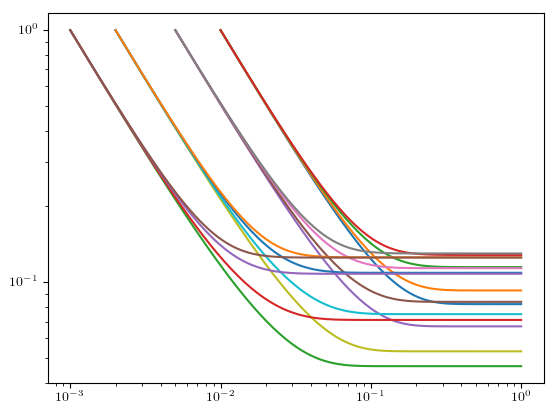

19.496533764767253


In [780]:
## dependence on two variables
N = 10000;k=20;m=20;l=10
N_range = [100,200,500,1000]#,200,320,440]#,800,1600,3200]
l_range = [10,15,18,19]
# N_range = [120,200,320,440]#,800,1600,3200]
# alpha_range = [0.01,0.1,0.4,0.6,0.8]#collect(0.01:0.1:0.5)
# beta_range = collect(-0.15:0.05:0.25)
alpha = 0.8;beta = 0.01
l1 = length(N_range)
l2 = length(l_range)
# l2 = length(N_range)
comm_ratio_arr = zeros(Float64,l1,l2)
pfixth_arr = zeros(Float64,l1,l2)
pfix_arr = zeros(Float64,l1,l2)
sim_ratio_arr = zeros(Float64,l1,l2)
succ_arr = zeros(Bool,l1,l2)
# beta = 0.05
use_model = true
num_trials = 4000
for (i,N) in enumerate(N_range)
    for (j,l) in enumerate(l_range)
#     for (j,N) in enumerate(N_range)
        t = get_t(N,k,m,l)
        comm_ratio_arr[i,j] = get_community_graph_fixation_ratio(t,alpha,beta)
        println(comm_ratio_arr[i,j])
        sim_ratio, succ,pfix,pfixth = get_theory_sim_fixation_ratio(t,alpha,beta,num_trials,use_model)
        sim_ratio_arr[i,j] = sim_ratio
        succ_arr[i,j] = succ
        pfix_arr[i,j] = pfix
        pfixth_arr[i,j] = pfixth
    end
end

In [781]:
#find phase transition boundary
using Dierckx
using Roots
yy = log.(comm_ratio_vec)
xx = collect(alpha_range)#collect(0:length(xx)-1)
f(x) = evaluate(Spline1D(xx,yy,k=1,bc="extrapolate"),x)
xxx = minimum(xx):0.1:maximum(xx)
plot(xxx,f(xxx))
plot(xx,yy)
xz = fzero(x -> f(x),minimum(xx),maximum(xx))
axvline(xz)
axhline(f(xz))

LoadError: [91mArgumentError: The interval [a,b] is not a bracketing interval.
You need f(a) and f(b) to have different signs (f(a) * f(b) < 0).
Consider a different bracket or try fzero(f, c) with an initial guess c.

[39m

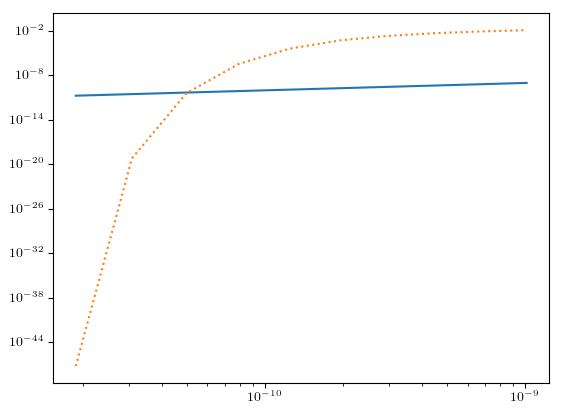

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1991ca210>

In [762]:
plot(comm_ratio_vec,pfixth_vec)
loglog(comm_ratio_vec,pfix_vec,":")
# plot(alpha_range,comm_ratio_vec,"--")
# axvline(xz)
# axvline(1)

17.17955598597577
393.950597 seconds (1.96 G allocations: 47.230 GiB, 2.63% gc time)
1.8488095244229785
375.601272 seconds (1.87 G allocations: 45.091 GiB, 2.62% gc time)
0.22445507618641047
352.275728 seconds (1.76 G allocations: 42.371 GiB, 2.58% gc time)
0.030363374623894848
226.127956 seconds (1.12 G allocations: 27.091 GiB, 2.57% gc time)
0.0045286355786571695
 22.264103 seconds (106.71 M allocations: 2.629 GiB, 2.58% gc time)
simulation didn't reach 1.0
theory suggests at least 721.6062736847215
0.0007379642388508925
 14.593799 seconds (68.30 M allocations: 1.703 GiB, 2.62% gc time)
simulation didn't reach 1.0
theory suggests at least 3664.4721890501323
0.00013035697207867418
 10.915306 seconds (49.90 M allocations: 1.259 GiB, 2.72% gc time)
simulation didn't reach 1.0
theory suggests at least 18333.20204581944
2.479028057333579e-5
  9.477736 seconds (42.46 M allocations: 1.080 GiB, 2.71% gc time)
simulation didn't reach 1.0
theory suggests at least 88161.63675310095
5.0449809494

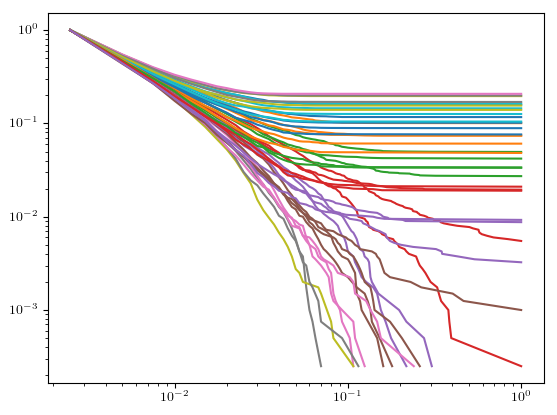

 61.241176 seconds (304.79 M allocations: 7.404 GiB, 2.90% gc time)


In [487]:
## dependence on two variables
N = 400;k=40;m=40;l=39
# N_range = [120,200,320,440]#,800,1600,3200]
alpha_range = [0.01,0.1,0.4,0.6,0.8]#collect(0.01:0.1:0.5)
beta_range = collect(-0.15:0.05:0.25)
l1 = length(alpha_range)
l2 = length(beta_range)
# l2 = length(N_range)
comm_ratio_arr = zeros(Float64,l1,l2)
pfixth_arr = zeros(Float64,l1,l2)
pfix_arr = zeros(Float64,l1,l2)
sim_ratio_arr = zeros(Float64,l1,l2)
succ_arr = zeros(Bool,l1,l2)
# beta = 0.05
num_trials = 4000
for (i,alpha) in enumerate(alpha_range)
    for (j,beta) in enumerate(beta_range)
#     for (j,N) in enumerate(N_range)
        t = get_t(N,k,m,l)
        comm_ratio_arr[i,j] = get_community_graph_fixation_ratio(t,alpha,beta)
        println(comm_ratio_arr[i,j])
        sim_ratio, succ,pfix,pfixth = get_theory_sim_fixation_ratio(t,alpha,beta,num_trials)
        sim_ratio_arr[i,j] = sim_ratio
        succ_arr[i,j] = succ
        pfix_arr[i,j] = pfix
        pfixth_arr[i,j] = pfixth
    end
end
    

In [776]:
comm_ratio_arr
sim_ratio_arr
pfix_arr#./pfixth_arr# pfix_arr

3×4 Array{Float64,2}:
 0.0820323  0.0929482  0.115002   0.12853  
 0.0465601  0.0710072  0.108195   0.125485 
 0.0339998  0.0454109  0.0559493  0.0553873

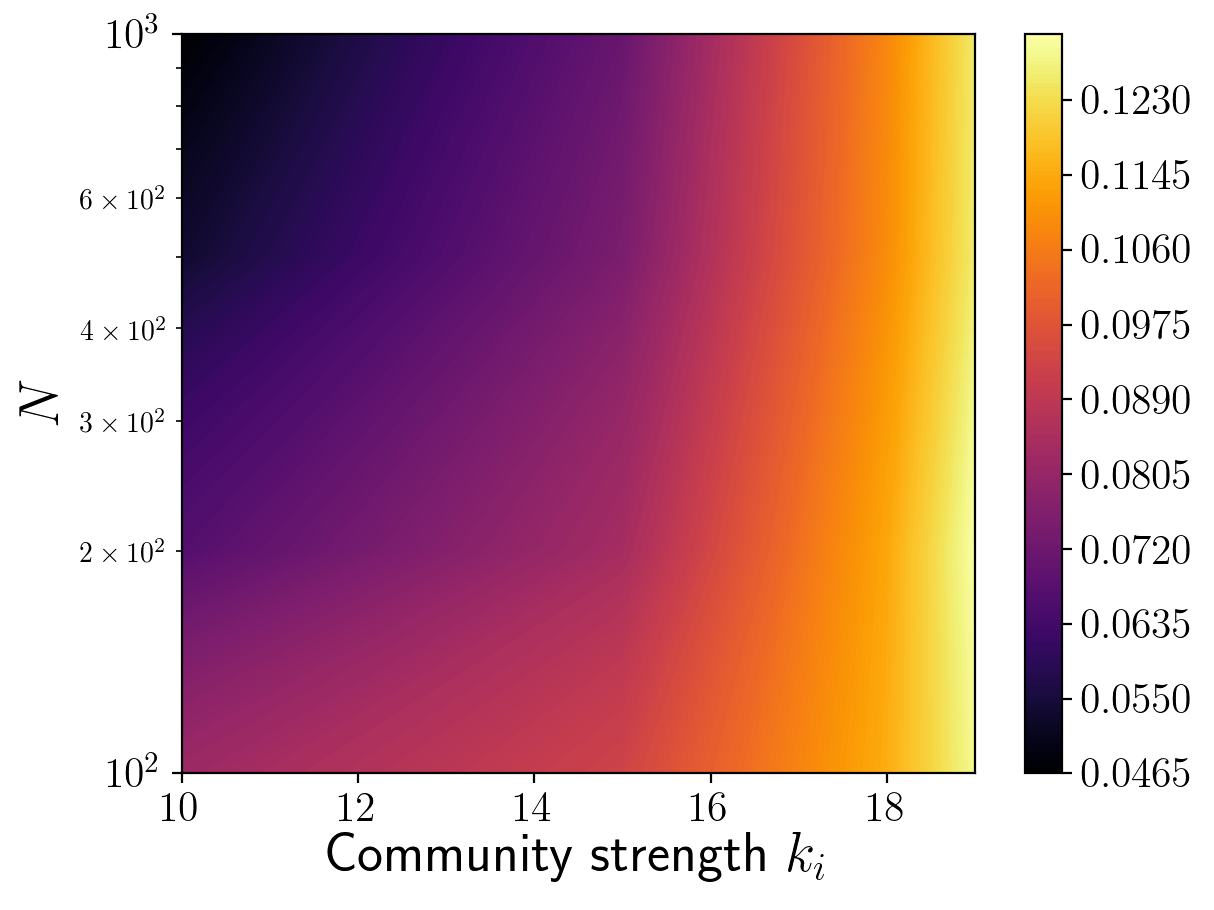

PyObject <matplotlib.text.Text object at 0x19a17e850>

In [785]:
eps = 0.0
tmp = clamp.(pfix_arr./pfixth_arr + eps,0.0,1.)
# tmp = sim_ratio_arr
# tmp[sim_ratio_arr .== 0] = (1/num_trials)./pfixth_arr[sim_ratio_arr .== 0]
# imshow(tmp)
figure(dpi=200)
# axhline(xz,color="k",linestyle ="-")
# contourf(beta_range,alpha_range,pfix_arr,200,vmin=eps,vmax = 1.,cmap="inferno")#,norm=matplotlib[:colors][:LogNorm](vmin=0.001,vmax=0.1,clip=true))#logspace(0,1,20)[1:end-1]))#) #cmap="inferno"
contourf(l_range,N_range,pfix_arr,200,cmap="inferno")#,norm=matplotlib[:colors][:LogNorm](vmin=0.001,vmax=0.1,clip=true))#logspace(0,1,20)[1:end-1]))#) #cmap="inferno"
cb = colorbar()#ticks=0:0.1:1)
# contour(beta_range,alpha_range,comm_ratio_arr,[1.0])
gca()[:tick_params](labelsize=15)
cb[:ax][:tick_params](labelsize=15)
gca()[:set_yscale]("log")
xlabel(L"Community strength $k_i$",size=20)
ylabel(L"$N$",size=20)

In [610]:
##

4-element Array{Float64,1}:
 0.001
 0.01 
 0.1  
 1.0  

- Emergence of global cascades is only possible for sufficiently high clustering. Key is the transition from u-shaped to peaked distribution of infecteds? Can we predict analytically where in terms of $k_i$ this transition will happen? Look at the values of $\delta$ etc.

# Testing case where fixation in one direction in one subcommunity is much more likely than the other

In [2]:
N = 400 #1000
c_r = 0.1

# alpha,beta = 2.0,0.2

k = 40 #50
m = 40 #50#0.5: m=14,l=9,r=1 $ 0.3: m = 10, l = 7, r = 3
l = 39 #49


39

0.1 0.04
0.014502969605293205
 52.285573 seconds (223.34 M allocations: 4.872 GiB, 2.23% gc time)
0.1 0.04
0.014502969605293205
121.978799 seconds (632.82 M allocations: 15.312 GiB, 2.22% gc time)
0.1 0.04
0.014502969605293205
182.492893 seconds (2.22 G allocations: 44.773 GiB, 5.11% gc time)
0.1 0.04
0.014502969605293205
274.998815 seconds (3.88 G allocations: 75.282 GiB, 6.66% gc time)
simulation didn't reach 1.0
theory suggests at least 242.71902880346843
0.1 0.04
0.014502969605293205
925.319490 seconds (12.60 G allocations: 244.858 GiB, 7.55% gc time)


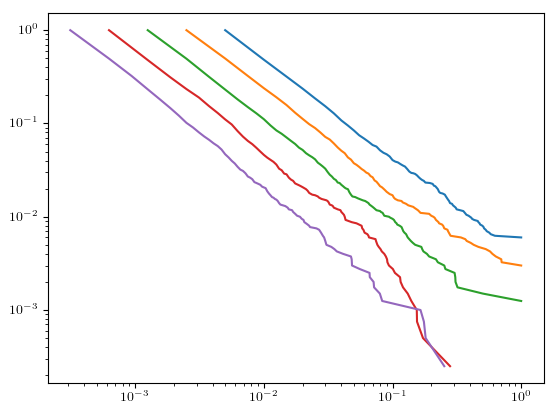

simulation didn't reach 1.0
theory suggests at least 242.71902880346843


In [364]:
sim_ratio_arr = Float64[]
N_ratio_arr = Float64[]
comm_ratio_arr = Float64[]
pfix_arr = Float64[]
pfixth_arr = Float64[]
pfix_rnd_arr = Float64[]
succ_arr = Bool[]
# y_n_range = collect(0.1:0.05:0.5)
y_n = 0.1
N_range = [200,400,800,1600,3200]
num_trials = 4000
# for y_n in y_n_range
for N in N_range 
    t = get_t(N,k,m,l)
    alpha,beta = 0.1,0.04#1.0,0.343#1.0,0.2#get_alpha_beta(N,c_r,y_n)
    println(alpha, " ", beta)
    comm_ratio = get_community_graph_fixation_ratio(t,alpha,beta)
    println(comm_ratio)
    sim_ratio, succ,pfix,pfixth = get_theory_sim_fixation_ratio(t,alpha,beta,num_trials)
    im = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,k,N) , x -> 1 + beta)
# im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta)
    ppr = P_reach_fast(im,N,1.0/N,yyr,true)
    push!(N_ratio_arr,N/m)
    push!(pfixth_arr,pfixth)
    push!(pfix_rnd_arr,ppr[end])
    push!(succ_arr,succ)
    push!(pfix_arr,pfix)
    push!(sim_ratio_arr,sim_ratio)
    push!(comm_ratio_arr,comm_ratio)
end
    

In [354]:
comm_ratio_arr,N_ratio_arr

([0.0507315, 0.0507315, 0.0507315, 0.0507315, 0.0507315], [5.0, 10.0, 20.0, 40.0, 80.0])

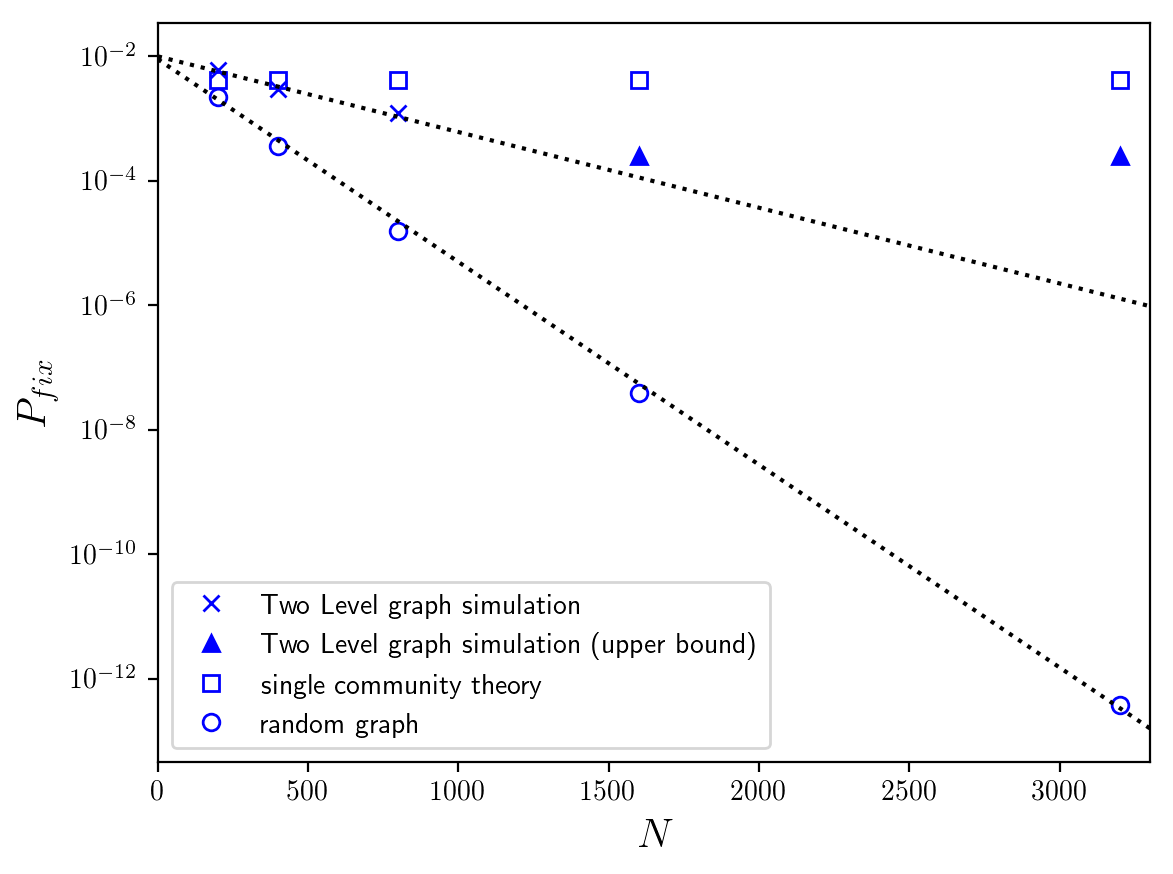

PyObject <matplotlib.legend.Legend object at 0x14b138ad0>

In [389]:
figure(dpi=200)
# tick_params("y",colors="g")
semilogy(N_range,pfix_arr,"xb",label="Two Level graph simulation")
semilogy(N_range[.~succ_arr],1/num_trials*ones(pfix_arr)[.~succ_arr],"^b",label="Two Level graph simulation (upper bound)")
semilogy(N_range,pfixth_arr,"sb",fillstyle="none",label="single community theory")
semilogy(N_range,pfix_rnd_arr,"ob",fillstyle="none",label="random graph")
# axhline(pfixth_arr[1],linestyle=":",color="k")
nn = collect(0:100:3300)
# semilogy(nn,0.04*exp.(-nn.*0.0145),":k")
semilogy(nn,0.01*exp.(-nn.*0.0028),":k")
semilogy(nn,0.009*exp.(-nn.*0.0075),":k")
# ylim([1e-80,1e80])
# ylim([1e-2,1e2])
xlabel(L"$N$",size=15)
ylabel(L"$P_{fix}$",size=15)
xlim([0,3300])
# gca()[:set_xlabel]("hi",size=15)
legend(loc="best")
# ylim([1e-6,1])
# fig = gcf()
# fig[:set_size_inches](1.5, 1.5)

# twinx()
# tick_params("y",colors="b")
# semilogy(y_n_range,comm_ratio_arr,"sb",fillstyle="none",label="forward/backward ratio of fixation in single community")
# semilogy(N_range,comm_ratio_arr,"sb",fillstyle="none",label="forward/backward ratio of fixation in single community")
# ylim([1e-15,1e15])
# legend(loc=(0.0,-0.2))

# axhline(-1,linestyle="--")
# sim_ratio_arr


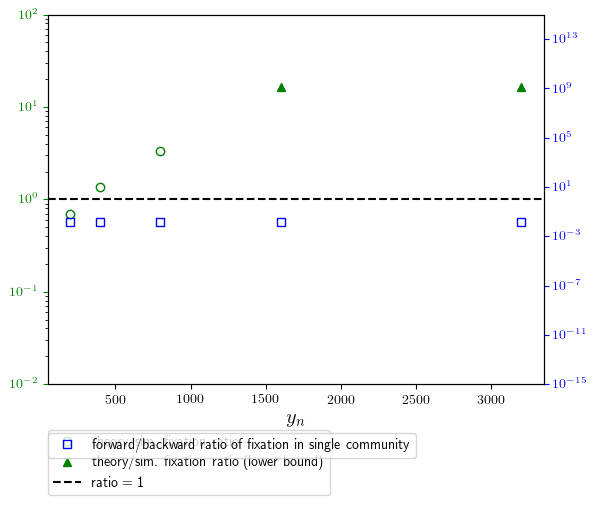

5-element Array{Float64,1}:
 1.45631  
 0.728157 
 0.303399 
 0.0606798
 0.0606798

In [366]:
tick_params("y",colors="g")
semilogy(N_range[succ_arr],1./sim_ratio_arr[succ_arr],"og",fillstyle="none",label="theory/sim. fixation ratio")
semilogy(N_range[.~succ_arr],1./sim_ratio_arr[.~succ_arr],"^g",label="theory/sim. fixation ratio (lower bound)")
axhline(1,linestyle="--",color="k",label="ratio = 1")
ylim([1e-2,1e2])
xlabel(L"$y_n$",size=15)
# gca()[:set_xlabel]("hi",size=15)
legend(loc=(0.0,-0.3))
twinx()
tick_params("y",colors="b")
semilogy(N_range,comm_ratio_arr,"sb",fillstyle="none",label="forward/backward ratio of fixation in single community")
ylim([1e-15,1e15])
legend(loc=(0.0,-0.2))

# axhline(-1,linestyle="--")
sim_ratio_arr


In [116]:
comm_ratio_arr,N_range/m

([1.21992e12, 9.00398e11, 3.75406e11, 9.7509e10], [8.0, 16.0, 40.0, 80.0])

# General experiments

In [788]:
N = 1000 #1000
c_r = 0.1 #0.2
y_n = 0.1 #0.1

n_n = Int(N*y_n)#y_n*N
beta = get_beta(N,c_r,n_n)#4.0/(c_r*n_n)
alpha = get_alpha(N,c_r,n_n)#(N*beta)/n_n
alpha,beta = 1.0,0.2

k = 40 #50
m = 40 #50#0.5: m=14,l=9,r=1 $ 0.3: m = 10, l = 7, r = 3
l = 39 #49
r = k -l
t = TwoLevel(Int(ceil(N/m)*m),m,l,r)
# y = 0.005
# t.i = Int(round(t.N*y))
# arr = TwoLevelGraphs.get_stationary_distribution_nlsolve_finite_size(t,alpha,beta)
# semilogy(0:length(arr)-1,arr,"o")
# println(arr)

74.04989011181446

In [812]:
N = 10000 #1000

alpha,beta = 2.0,0.2

k = 20 #50
m = 20 #50#0.5: m=14,l=9,r=1 $ 0.3: m = 10, l = 7, r = 3
l = 19 #49
r = k -l
t = TwoLevel(Int(ceil(N/m)*m),m,l,r)
comm_ratio = get_community_graph_fixation_ratio(t,alpha,beta)



381.331003887621

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Float64}, ::Int64, ::Int64) at ./deprecated.jl:57
 [3] trust_region_(::NLsolve.DifferentiableMultivariateFunction, ::Array{Float64,1}, ::Float64, ::Float64, ::Int64, ::Bool, ::Bool, ::Bool, ::Float64, ::Bool) at /Users/julian/.julia/v0.6/NLsolve/src/trust_region.jl:82
 [4] #nlsolve#17(::Symbol, ::Float64, ::Float64, ::Int64, ::Bool, ::Bool, ::Bool, ::Function, ::Float64, ::Bool, ::NLsolve.#nlsolve, ::NLsolve.DifferentiableMultivariateFunction, ::Array{Float64,1}) at /Users/julian/.julia/v0.6/NLsolve/src/nlsolve_func_defs.jl:24
 [5] (::NLsolve.#kw##nlsolve)(::Array{Any,1}, ::NLsolve.#nlsolve, ::NLsolve.DifferentiableMultivariateFunction, ::Array{Float64,1}) at ./<missing>:0
 [6] #nlsolve#19(::Symbol, ::Float64, ::Float64, ::Int64, ::Bool, ::Bool, ::Bool, ::Function, ::Float64, ::Bool, ::Bool, ::NLsolve.#nlsolve, ::TwoLevelGraphs.#fn#12{TwoLevelGraphs.TwoLevel,Float64,Float64}, ::Array{Float64,1}) at /Us

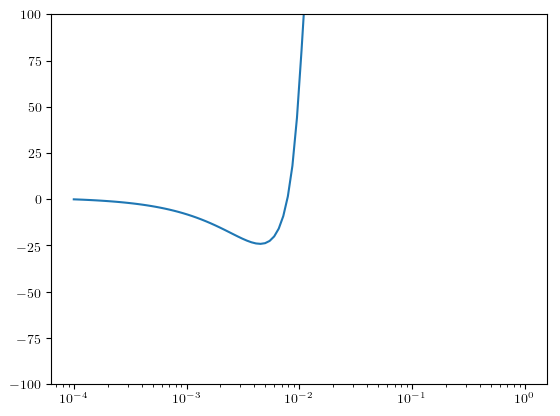

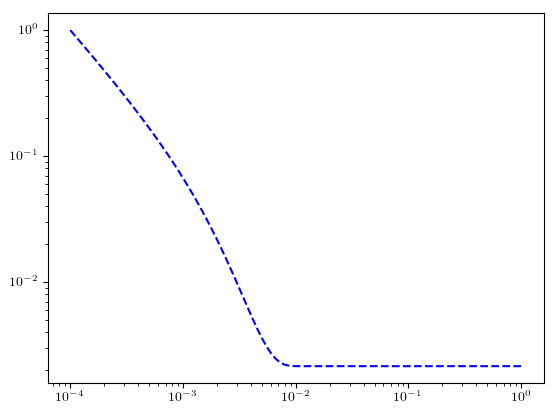

3.889993 seconds (53.34 M allocations: 1.134 GiB, 6.17% gc time)
0.0021583511074910063


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1a07c0090>

In [813]:
@time yytl,pptl,s_eff_two_level = get_p_reach_theory(t,alpha,beta,N,true,num_points)
println(pptl[end])
semilogx(yytl,N*cumsum(s_eff_two_level(yytl).*yytl))
ylim([-100,100])
figure()
loglog(yytl,pptl,"--b",label="two level theory")

0.8 0.01


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Float64}, ::Int64, ::Int64) at ./deprecated.jl:57
 [3] trust_region_(::NLsolve.DifferentiableMultivariateFunction, ::Array{Float64,1}, ::Float64, ::Float64, ::Int64, ::Bool, ::Bool, ::Bool, ::Float64, ::Bool) at /Users/julian/.julia/v0.6/NLsolve/src/trust_region.jl:82
 [4] #nlsolve#17(::Symbol, ::Float64, ::Float64, ::Int64, ::Bool, ::Bool, ::Bool, ::Function, ::Float64, ::Bool, ::NLsolve.#nlsolve, ::NLsolve.DifferentiableMultivariateFunction, ::Array{Float64,1}) at /Users/julian/.julia/v0.6/NLsolve/src/nlsolve_func_defs.jl:24
 [5] (::NLsolve.#kw##nlsolve)(::Array{Any,1}, ::NLsolve.#nlsolve, ::NLsolve.DifferentiableMultivariateFunction, ::Array{Float64,1}) at ./<missing>:0
 [6] #nlsolve#19(::Symbol, ::Float64, ::Float64, ::Int64, ::Bool, ::Bool, ::Bool, ::Function, ::Float64, ::Bool, ::Bool, ::NLsolve.#nlsolve, ::TwoLevelGraphs.#fn#12{TwoLevelGraphs.TwoLevel,Float64,Float64}, ::Array{Float64,1}) at /Us

  2.899468 seconds (36.86 M allocations: 800.352 MiB, 6.16% gc time)
 17.124029 seconds (260.18 M allocations: 5.533 GiB, 8.16% gc time)
 17.156614 seconds (260.46 M allocations: 5.546 GiB, 8.15% gc time)


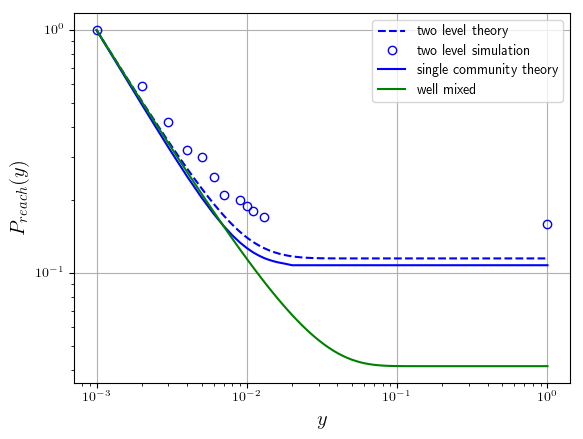

21.566795523816705 >? 50.0


PyObject <matplotlib.legend.Legend object at 0x19cfab4d0>

In [787]:

println(alpha," ", beta)
im_normal = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);

num_points = 100
@time yytl,pptl,s_eff_two_level = get_p_reach_theory(t,alpha,beta,N,true,num_points)

# N = Int(round(N/m))
yyr = logspace(log10(1/N),0,100)
im = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,k,N) , x -> 1 + beta)
# im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta)
ppr = P_reach_fast(im,N,1.0/N,yyr,true)
@time yys,pps = get_simulation_yy_pp(t,alpha,beta,100)

loglog(yytl,pptl,"--b",label="two level theory")
loglog(yys,pps,"ob",fillstyle="none",label="two level simulation")
yy,pp,pp_reverse = get_single_community_fixation(t,alpha,beta)
println(pp[end]/pp_reverse[end], " >? ", N/m)
yy = m/N*yy
push!(yy,1.0)
push!(pp,pp[end])
loglog(yy,pp,"-b",label="single community theory")
loglog(yyr,ppr,"-g",label="well mixed")
xlabel(L"$y$",size=15)
ylabel(L"$P_{reach}(y)$",size=15)
# ylim([1e-10,1])
grid()
legend()

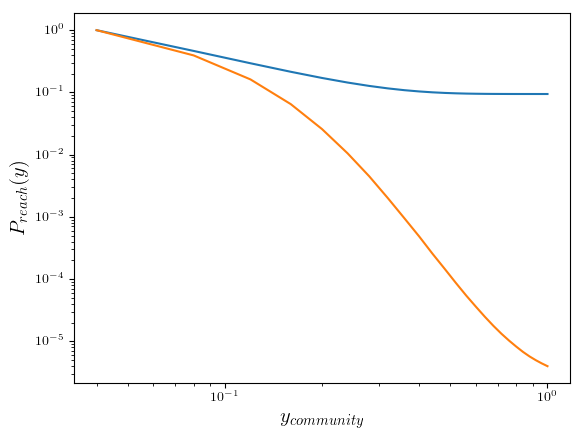

26-element Array{Float64,1}:
 -3.83555e6  
  1.0        
  0.392797   
  0.161617   
  0.0647399  
  0.0257015  
  0.0104884  
  0.00449163 
  0.00199532 
  0.000948517
  0.000484651
  0.000255309
  0.000145932
  8.64878e-5 
  5.41006e-5 
  3.58503e-5 
  2.46261e-5 
  1.76434e-5 
  1.31811e-5 
  1.0244e-5  
  8.2026e-6  
  6.72722e-6 
  5.69613e-6 
  4.95811e-6 
  4.4044e-6  
  3.97417e-6 

In [145]:
#slightly asymetric for alpha,beta = 0 because all other nodes on the graph are considered susceptible
yy,pp,pp_reverse = get_single_community_fixation(t,alpha,beta,false)
# yy,pp,pp_reverse = get_single_community_fixation(t,0,0)
figure()
loglog(yy,pp)
loglog(yy,pp_reverse)
xlabel(L"$y_{community}$",size=15)
ylabel(L"$P_{reach}(y)$",size=15)
pp_reverse

In [8]:

Spline1D(1-y_range[end:-1:1],-s_arr[end:-1:1],k=interpolation_order,bc="extrapolate")

Spline1D(knots=[0.0,0.04 … 0.96,1.0] (49 elements), k=3, extrapolation="extrapolate", residual=0.0)

We consider two regimes.


- In the opposite regime, where infection is much more likely than uninfection, the fixation probability is asymptotically the same as the fixation probability in just one supernode. This is because the number of edges between A and B nodes is the same, so the rate at which a single A node or a single B node get infected are the same. If the forward fixation is much higher, then it is much more likely that a second community becomes infected. Now for dying out we would need backward to happen twice (goes like ratio squared, etc.) which becomes exponentially unlikely. Thus the figure of merit is infecting the second community vs. dying out. So we just need to compare forward/backward to 1.

- is it possible that for high clustering (where each community gets infected one after the other), $P_{fix}$ never scales with $N$? There is always a finite number $c$ of communities such that $P_{forward}^c$ of all those communities dominates over $P_{backward}$?

## is there a critical clustering threshold? Measure this as a function of $\frac{k_i}{k}$

# TODO analyze this. 

- In one the probability of one supernode becoming infected is equal as the probability of it becoming uninfected (starting with one of the opposite type, respectively). In that case the probability of infection is like a neutral process in supernode space. 


Two level theory brakes down when $N$ becomes very large. Why? does the equilibrium assumption break down?
- This happens in particular for very high clustering.
- For large N

## Is it possible that the equilibrium underestimates how strongly the distribution is concentrated at the edges?

## Is there a critical clustering threshold (above which there is no scaling with N) for random clustered graphs? Is that threshold predicted by our clustering theory?